In [1]:
!pip install pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:0

In [ ]:
import os
import sys
import time
import gc
import sklearn
import pandas as pd
import cv2
import csv
import numpy as np
import random
import math
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torchvision
import pretrainedmodels
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pydicom
from PIL import Image
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from pathlib import Path
import logging as l
from glob import glob
import re
from sklearn.model_selection import KFold
import shutil

# Set random seeds for reproducibility
torch.manual_seed(1992)
torch.cuda.manual_seed(1992)
np.random.seed(1992)
random.seed(1992)
torch.backends.cudnn.benchmark = True

# Settings and Configuration
train_png_dir = '/kaggle/working/train_png/'
test_png_dir = '/kaggle/working/test_png/'
csv_path = '/kaggle/working/stage1_train_cls.csv'
test_csv_path = '/kaggle/working/stage2_test_cls.csv'
model_snapshot_path = '/kaggle/working/DenseNet121_change_avg/'
kfold_path = '/kaggle/working/fold_5_by_study_image/'
Image_size = 256
train_batch_size = 32
val_batch_size = 32
workers = 4
backbone = 'DenseNet121_change_avg'
is_center = False
is_aug = True
num_aug = 10

# Ensure directories exist
os.makedirs(train_png_dir, exist_ok=True)
os.makedirs(test_png_dir, exist_ok=True)
os.makedirs(model_snapshot_path, exist_ok=True)
os.makedirs(os.path.join(model_snapshot_path, 'prediction/npy_train'), exist_ok=True)
os.makedirs(os.path.join(model_snapshot_path, 'prediction/npy_test'), exist_ok=True)
os.makedirs(kfold_path, exist_ok=True)

# Common Utilities
def conv1x1(in_channels, out_channels, stride=1, groups=1, bias=False):
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, groups=groups, bias=bias)

def conv3x3(in_channels, out_channels, stride=1, padding=1, dilation=1, groups=1, bias=False):
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)

def depthwise_conv3x3(channels, stride):
    return nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=stride, padding=1, groups=channels, bias=False)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation=1, groups=1, bias=False, bn_eps=1e-5, activation=(lambda: nn.ReLU(inplace=True)), activate=True):
        super(ConvBlock, self).__init__()
        self.activate = activate
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(num_features=out_channels, eps=bn_eps)
        if self.activate:
            if callable(activation):
                self.activ = activation()
            elif isinstance(activation, str):
                if activation == "relu":
                    self.activ = nn.ReLU(inplace=True)
                elif activation == "relu6":
                    self.activ = nn.ReLU6(inplace=True)
                else:
                    raise NotImplementedError()
            else:
                self.activ = activation

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x

# Data Preparation
l.basicConfig(level=l.INFO, format='%(levelname)s: %(message)s')
logger = l.getLogger()

def get_first_of_dicom_field_as_int(x):
    return int(x[0]) if isinstance(x, pydicom.multival.MultiValue) else int(x)

def get_id(img_dicom):
    return str(img_dicom.SOPInstanceUID)

def get_metadata_from_dicom(img_dicom):
    metadata = {
        "window_center": img_dicom.WindowCenter,
        "window_width": img_dicom.WindowWidth,
        "intercept": img_dicom.RescaleIntercept,
        "slope": img_dicom.RescaleSlope,
    }
    return {k: get_first_of_dicom_field_as_int(v) for k, v in metadata.items()}

def window_image(img, window_center, window_width, intercept, slope):
    img = img * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def normalize_minmax(img):
    mi, ma = img.min(), img.max()
    return (img - mi) / (ma - mi + 1e-5)

def save_img(img_pil, output_folder, name):
    os.makedirs(output_folder, exist_ok=True)
    img_pil.save(os.path.join(output_folder, f"{name}.png"))

def prepare_image(img_path):
    img_dicom = pydicom.dcmread(img_path)
    img_id = get_id(img_dicom)
    metadata = get_metadata_from_dicom(img_dicom)
    img = window_image(img_dicom.pixel_array, **metadata)
    img = normalize_minmax(img) * 255
    img = Image.fromarray(img.astype(np.uint8), mode="L")
    return img_id, img

def prepare_and_save(img_path, output_folder):
    try:
        img_id, img_pil = prepare_image(img_path)
        save_img(img_pil, output_folder, img_id)
        logger.info(f"Successfully converted: {img_path} -> {os.path.join(output_folder, f'{img_id}.png')}")
    except Exception as e:
        logger.error(f"Error processing image: {img_path} | {e}")

def prepare_images_njobs(img_paths, output_folder, n_jobs=1):
    os.makedirs(output_folder, exist_ok=True)
    joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(prepare_and_save)(i, output_folder) for i in tqdm(img_paths)
    )

# Convert DICOM to PNG
train_dcm_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train'
test_dcm_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test'
train_dcm_files = glob(os.path.join(train_dcm_path, '*.dcm'))
test_dcm_files = glob(os.path.join(test_dcm_path, '*.dcm'))
print(f"Found {len(train_dcm_files)} training DICOM files")
print(f"Found {len(test_dcm_files)} test DICOM files")
print("Converting all training images...")
prepare_images_njobs(train_dcm_files, train_png_dir, n_jobs=1)
print("Converting all test images...")
prepare_images_njobs(test_dcm_files, test_png_dir, n_jobs=1)
print(f"Final Training PNGs: {len(os.listdir(train_png_dir))}")
print(f"Final Test PNGs: {len(os.listdir(test_png_dir))}")

# Preprocess CSVs
train_csv_input = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv'
test_csv_input = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv'

def preprocess_csv(input_path, output_path):
    csv = pd.read_csv(input_path)
    print(f"Processing {input_path}")
    print(f"Initial shape: {csv.shape}")
    print(f"Columns: {csv.columns.tolist()}")
    if csv['ID'].duplicated().any():
        print(f"Warning: Found {csv['ID'].duplicated().sum()} duplicate IDs")
    csv['study_instance_uid'] = csv['ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))
    csv['label_type'] = csv['ID'].apply(lambda x: x.split('_')[-1])
    expected_labels = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    actual_labels = csv['label_type'].unique()
    print(f"Label types found: {actual_labels}")
    if not all(label in expected_labels for label in actual_labels):
        print(f"Warning: Unexpected label types: {set(actual_labels) - set(expected_labels)}")
    duplicates = csv.duplicated(subset=['study_instance_uid', 'label_type']).sum()
    if duplicates > 0:
        print(f"Warning: Found {duplicates} duplicate study_instance_uid/label_type combinations")
    pivot = csv.pivot_table(
        index='study_instance_uid',
        columns='label_type',
        values='Label',
        aggfunc='max'
    ).reset_index()
    pivot['filename'] = pivot['study_instance_uid'] + '.png'
    pivot['slice_id'] = pivot['study_instance_uid'] + '_0'
    for label in expected_labels:
        if label not in pivot.columns:
            pivot[label] = 0
    pivot = pivot[['filename', 'study_instance_uid', 'slice_id'] + expected_labels]
    pivot.to_csv(output_path, index=False)
    print(f"Preprocessed CSV saved to: {output_path}")
    print(f"Output shape: {pivot.shape}")
    print(f"Output columns: {pivot.columns.tolist()}")
    return pivot

train_pivot = preprocess_csv(train_csv_input, csv_path)
test_pivot = preprocess_csv(test_csv_input, test_csv_path)

# Create K-Fold Splits
train_df = pd.read_csv(csv_path)
study_ids = train_df['study_instance_uid'].unique()
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1992)
for fold, (train_idx, val_idx) in enumerate(kf.split(study_ids)):
    train_studies = study_ids[train_idx]
    val_studies = study_ids[val_idx]
    fold_dir = os.path.join(kfold_path, f'fold{fold}')
    os.makedirs(fold_dir, exist_ok=True)
    with open(os.path.join(fold_dir, 'train.txt'), 'w') as f:
        for study in train_studies:
            f.write(study + '\n')
    with open(os.path.join(fold_dir, 'val.txt'), 'w') as f:
        for study in val_studies:
            f.write(study + '\n')
    print(f"Fold {fold}: {len(train_studies)} training studies, {len(val_studies)} validation studies")

# Data Augmentation and Dataset Utilities
def randomHorizontalFlip(image, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
    return image

def randomVerticleFlip(image, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 0)
    return image

def randomRotate90(image, u=0.5):
    if np.random.random() < u:
        image = np.rot90(image)
    return image

def random_cropping(image, ratio=0.8, is_random=True):
    height, width = image.shape[:2]
    target_h = int(height * ratio)
    target_w = int(width * ratio)
    if is_random:
        start_x = random.randint(0, width - target_w)
        start_y = random.randint(0, height - target_h)
    else:
        start_x = (width - target_w) // 2
        start_y = (height - target_h) // 2
    zeros = image[start_y:start_y+target_h, start_x:start_x+target_w]
    zeros = cv2.resize(zeros, (width, height))
    return zeros

def cropping(image, ratio=0.8, code=0):
    height, width = image.shape[:2]
    target_h = int(height * ratio)
    target_w = int(width * ratio)
    if code == 0:
        start_x = (width - target_w) // 2
        start_y = (height - target_h) // 2
    elif code == 1:
        start_x = 0
        start_y = 0
    elif code == 2:
        start_x = width - target_w
        start_y = 0
    elif code == 3:
        start_x = 0
        start_y = height - target_h
    elif code == 4:
        start_x = width - target_w
        start_y = height - target_h
    elif code == -1:
        return image
    zeros = image[start_y:start_y+target_h, start_x:start_x+target_w]
    zeros = cv2.resize(zeros, (width, height))
    return zeros

def random_erasing(img, probability=0.5, sl=0.02, sh=0.4, r1=0.3):
    if random.uniform(0, 1) > probability:
        return img
    for attempt in range(100):
        area = img.shape[0] * img.shape[1]
        target_area = random.uniform(sl, sh) * area
        aspect_ratio = random.uniform(r1, 1 / r1)
        h = int(round(math.sqrt(target_area * aspect_ratio)))
        w = int(round(math.sqrt(target_area / aspect_ratio)))
        if w < img.shape[1] and h < img.shape[0]:
            x1 = random.randint(0, img.shape[0] - h)
            y1 = random.randint(0, img.shape[1] - w)
            img[x1:x1 + h, y1:y1 + w] = 0.0
            return img
    return img

def randomShiftScaleRotate(image, shift_limit=(-0.1, 0.1), scale_limit=(-0.1, 0.1), rotate_limit=(-30, 30), aspect_limit=(-0.1, 0.1), borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width = image.shape[:2]
        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)
        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])
        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height]])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])
        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode, borderValue=0)
    return image

def aug_image(image, is_infer=False, augment=[0, 0]):
    if is_infer:
        image = randomHorizontalFlip(image, u=augment[0])
        image = cropping(image, ratio=0.8, code=augment[1])
        return image
    else:
        image = randomHorizontalFlip(image)
        image = randomVerticleFlip(image)
        image = randomRotate90(image)
        image = randomShiftScaleRotate(image, shift_limit=(-0.1, 0.1), scale_limit=(-0.1, 0.1), rotate_limit=(-30, 30), aspect_limit=(-0.1, 0.1))
        image = random_erasing(image, probability=0.5, sl=0.02, sh=0.4, r1=0.3)
        ratio = random.uniform(0.6, 0.99)
        image = random_cropping(image, ratio=ratio, is_random=True)
        return image

def generate_random_list(length):
    if length <= 0:
        return [0]
    new_list = []
    for i in range(length):
        if i <= length / 2:
            weight = int(i / 4)
        else:
            weight = int((length - i) / 4)
        weight = max(1, weight)
        new_list += [i] * weight
    return new_list

def generate_transforms(image_size):
    train_transform = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ])
    val_transform = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ])
    return train_transform, val_transform

class RSNA_Dataset_train_by_study_context(torch.utils.data.Dataset):
    def __init__(self, df, name_list, img_dir=train_png_dir, transform=None):
        valid_names = set(df['study_instance_uid'])
        self.name_list = [name for name in name_list if name in valid_names]
        if len(self.name_list) < len(name_list):
            print(f"Warning: {len(name_list) - len(self.name_list)} study_instance_uids in name_list not found in df")
        self.df = df[df['study_instance_uid'].isin(self.name_list)]
        self.img_dir = img_dir
        self.transform = transform
        self.labels = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        if self.df.empty:
            print("Error: DataFrame is empty after filtering with name_list")

    def __getitem__(self, idx):
        study_name = self.name_list[idx % len(self.name_list)]
        study_train_df = self.df[self.df['study_instance_uid'] == study_name]
        if study_train_df.empty:
            print(f"Warning: No data for study_instance_uid {study_name}")
            image_cat = np.zeros((256, 256, 3), dtype=np.uint8)
            label = torch.FloatTensor([0, 0, 0, 0, 0, 0])
            if self.transform is not None:
                augmented = self.transform(image=image_cat)
                image_cat = augmented['image']
            return image_cat, label
        study_index = random.choice(generate_random_list(study_train_df.shape[0] - 1))
        slice_id = study_name + '_' + str(study_index)
        filename = study_train_df[study_train_df['slice_id'] == slice_id]['filename'].values
        if len(filename) == 0:
            print(f"Warning: No filename for slice_id {slice_id}")
            image_cat = np.zeros((256, 256, 3), dtype=np.uint8)
            label = torch.FloatTensor([0, 0, 0, 0, 0, 0])
            if self.transform is not None:
                augmented = self.transform(image=image_cat)
                image_cat = augmented['image']
            return image_cat, label
        filename = filename[0]
        image = cv2.imread(os.path.join(self.img_dir, filename), cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error loading image: {filename}")
            image = np.zeros((256, 256), dtype=np.uint8)
        if study_index == (study_train_df.shape[0] - 1):
            filename_up = filename
        else:
            slice_id_up = study_name + '_' + str(study_index + 1)
            filename_up = study_train_df[study_train_df['slice_id'] == slice_id_up]['filename'].values
            filename_up = filename_up[0] if len(filename_up) > 0 else filename
        if study_index == 0:
            filename_down = filename
        else:
            slice_id_down = study_name + '_' + str(study_index - 1)
            filename_down = study_train_df[study_train_df['slice_id'] == slice_id_down]['filename'].values
            filename_down = filename_down[0] if len(filename_down) > 0 else filename
        image_up = cv2.imread(os.path.join(self.img_dir, filename_up), cv2.IMREAD_GRAYSCALE)
        if image_up is None:
            image_up = image.copy()
        image_down = cv2.imread(os.path.join(self.img_dir, filename_down), cv2.IMREAD_GRAYSCALE)
        if image_down is None:
            image_down = image.copy()
        image = cv2.resize(image, (256, 256))
        image_up = cv2.resize(image_up, (256, 256))
        image_down = cv2.resize(image_down, (256, 256))
        image_cat = np.stack([image_up, image, image_down], axis=-1)
        label = torch.FloatTensor(study_train_df[study_train_df['filename'] == filename][self.labels].values[0])
        image_cat = aug_image(image_cat, is_infer=False)
        if self.transform is not None:
            augmented = self.transform(image=image_cat)
            image_cat = augmented['image']
        return image_cat, label

    def __len__(self):
        return len(self.name_list) * 4

class RSNA_Dataset_val_by_study_context(torch.utils.data.Dataset):
    def __init__(self, df, name_list, img_dir=train_png_dir, transform=None):
        valid_names = set(df['study_instance_uid'])
        self.name_list = [name for name in name_list if name in valid_names]
        if len(self.name_list) < len(name_list):
            print(f"Warning: {len(name_list) - len(self.name_list)} study_instance_uids in name_list not found in df")
        self.df = df[df['study_instance_uid'].isin(self.name_list)]
        self.img_dir = img_dir
        self.transform = transform
        self.labels = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        if self.df.empty:
            print("Error: DataFrame is empty after filtering with name_list")

    def __getitem__(self, idx):
        filename = self.name_list[idx % len(self.name_list)]
        filename_train_df = self.df[self.df['filename'] == filename]
        if filename_train_df.empty:
            print(f"Warning: No data for filename {filename}")
            image_cat = np.zeros((256, 256, 3), dtype=np.uint8)
            label = torch.FloatTensor([0, 0, 0, 0, 0, 0])
            if self.transform is not None:
                augmented = self.transform(image=image_cat)
                image_cat = augmented['image']
            return image_cat, label
        study_name = filename_train_df['study_instance_uid'].values[0]
        study_index = int(filename_train_df['slice_id'].values[0].split('_')[-1])
        study_train_df = self.df[self.df['study_instance_uid'] == study_name]
        image = cv2.imread(os.path.join(self.img_dir, filename), cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error loading image: {filename}")
            image = np.zeros((256, 256), dtype=np.uint8)
        if study_index == (study_train_df.shape[0] - 1):
            filename_up = filename
        else:
            slice_id_up = study_name + '_' + str(study_index + 1)
            filename_up = study_train_df[study_train_df['slice_id'] == slice_id_up]['filename'].values
            filename_up = filename_up[0] if len(filename_up) > 0 else filename
        if study_index == 0:
            filename_down = filename
        else:
            slice_id_down = study_name + '_' + str(study_index - 1)
            filename_down = study_train_df[study_train_df['slice_id'] == slice_id_down]['filename'].values
            filename_down = filename_down[0] if len(filename_down) > 0 else filename
        image_up = cv2.imread(os.path.join(self.img_dir, filename_up), cv2.IMREAD_GRAYSCALE)
        if image_up is None:
            image_up = image.copy()
        image_down = cv2.imread(os.path.join(self.img_dir, filename_down), cv2.IMREAD_GRAYSCALE)
        if image_down is None:
            image_down = image.copy()
        image = cv2.resize(image, (256, 256))
        image_up = cv2.resize(image_up, (256, 256))
        image_down = cv2.resize(image_down, (256, 256))
        image_cat = np.stack([image_up, image, image_down], axis=-1)
        label = torch.FloatTensor(study_train_df[study_train_df['filename'] == filename][self.labels].values[0])
        image_cat = aug_image(image_cat, is_infer=True)
        if self.transform is not None:
            augmented = self.transform(image=image_cat)
            image_cat = augmented['image']
        return image_cat, label

    def __len__(self):
        return len(self.name_list)

class PredictionDatasetPure(torch.utils.data.Dataset):
    def __init__(self, name_list, df_train, df_test, n_test_aug, mode, img_dir):
        self.name_list = name_list
        self.mode = mode
        self.n_test_aug = n_test_aug
        self.img_dir = train_png_dir if mode == 'val' else test_png_dir
        if mode == 'val':
            self.df = df_train[df_train['filename'].isin(name_list)]
        elif mode == 'test':
            self.df = df_test[df_test['filename'].isin(name_list)]
        self.labels = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        if self.df.empty:
            print(f"Error: DataFrame is empty for mode {mode}")

    def __len__(self):
        return len(self.name_list) * self.n_test_aug

    def __getitem__(self, idx):
        filename = self.name_list[idx % len(self.name_list)]
        image_cat = cv2.imread(os.path.join(self.img_dir, filename), cv2.IMREAD_GRAYSCALE)
        if image_cat is None:
            print(f"Error loading image: {filename}")
            image_cat = np.zeros((256, 256), dtype=np.uint8)
        image_cat = cv2.resize(image_cat, (256, 256))
        image_cat = np.stack([image_cat, image_cat, image_cat], axis=-1)
        label = torch.FloatTensor(self.df[self.df['filename'] == filename][self.labels].values[0] if self.mode == 'val' else [0, 0, 0, 0, 0, 0])
        image_cat = aug_image(image_cat, is_infer=True)
        image_cat = valid_transform_pure(image=image_cat)['image']
        return filename, image_cat, label

class PredictionDatasetAug(torch.utils.data.Dataset):
    def __init__(self, name_list, df_train, df_test, n_test_aug, mode, img_dir):
        self.name_list = name_list
        self.mode = mode
        self.n_test_aug = n_test_aug
        self.img_dir = train_png_dir if mode == 'val' else test_png_dir
        if mode == 'val':
            self.df = df_train[df_train['filename'].isin(name_list)]
        elif mode == 'test':
            self.df = df_test[df_test['filename'].isin(name_list)]
        self.labels = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        if self.df.empty:
            print(f"Error: DataFrame is empty for mode {mode}")

    def __len__(self):
        return len(self.name_list) * self.n_test_aug

    def __getitem__(self, idx):
        filename = self.name_list[idx % len(self.name_list)]
        image_cat = cv2.imread(os.path.join(self.img_dir, filename), cv2.IMREAD_GRAYSCALE)
        if image_cat is None:
            print(f"Error loading image: {filename}")
            image_cat = np.zeros((256, 256), dtype=np.uint8)
        image_cat = cv2.resize(image_cat, (256, 256))
        image_cat = np.stack([image_cat, image_cat, image_cat], axis=-1)
        if random.random() < 0.5:
            image_cat = cv2.cvtColor(image_cat, cv2.COLOR_GRAY2RGB)
        image_cat = randomHorizontalFlip(image_cat, u=0.5)
        ratio = random.uniform(0.6, 0.99)
        image_cat = random_cropping(image_cat, ratio=ratio, is_random=True)
        image_cat = valid_transform_aug(image=image_cat)['image']
        label = torch.FloatTensor(self.df[self.df['filename'] == filename][self.labels].values[0] if self.mode == 'val' else [0, 0, 0, 0, 0, 0])
        return filename, image_cat, label

valid_transform_aug = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, p=1.0),
    ToTensorV2()
])

valid_transform_pure = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, p=1.0),
    ToTensorV2()
])

def generate_dataset_loader(df_all, c_train, train_transform, train_batch_size, c_val, val_transform, val_batch_size, workers):
    train_dataset = RSNA_Dataset_train_by_study_context(df_all, c_train, train_png_dir, train_transform)
    val_dataset = RSNA_Dataset_val_by_study_context(df_all, c_val, train_png_dir, val_transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=workers, pin_memory=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)
    return train_loader, val_loader

# Loss Functions and Evaluation Metrics
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none', pos_weight=self.weight)(input, target)
        pt = torch.exp(-BCE_loss)
        focal_loss = (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

def rsna_log_loss(outputs, targets, weights=None):
    if weights is None:
        weights = torch.ones(outputs.shape[1], device=outputs.device)
    else:
        weights = torch.tensor(weights, device=outputs.device)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.clamp(min=1e-7, max=1-1e-7)
    loss = -weights * (targets * torch.log(outputs) + (1 - targets) * torch.log(1 - outputs))
    return loss.mean()

def computeAUROC(dataGT, dataPRED, classCount):
    outAUROC = []
    datanpGT = dataGT.cpu().numpy()
    datanpPRED = dataPRED.cpu().numpy()
    for i in range(classCount):
        outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
    return outAUROC

def weighted_log_loss(output, target, weight=[1, 1, 1, 1, 1, 1]):
    loss = torch.nn.BCELoss()
    loss_list = []
    for i in range(output.shape[1]):
        output_class = output[:, i]
        target_class = target[:, i]
        loss_class = loss(output_class, target_class)
        loss_list.append(float(loss_class.cpu().numpy()))
    loss_sum = np.mean(np.array(weight) * np.array(loss_list))
    loss_list = [round(x, 4) for x in loss_list]
    loss_sum = round(loss_sum, 4)
    return loss_list, loss_sum

def weighted_log_loss_numpy(output, target, weight=[1, 1, 1, 1, 1, 1]):
    loss_list = []
    for i in range(output.shape[1]):
        output_class = output[:, i]
        target_class = target[:, i]
        loss_class = log_loss(target_class.ravel(), output_class.ravel(), eps=1e-7)
        loss_list.append(loss_class)
    loss_sum = np.mean(np.array(weight) * np.array(loss_list))
    loss_list = [round(x, 4) for x in loss_list]
    loss_sum = round(loss_sum, 4)
    return loss_list, loss_sum

class WarmRestart(torch.optim.lr_scheduler.CosineAnnealingLR):
    def __init__(self, optimizer, T_max=10, T_mult=2, eta_min=0, last_epoch=-1):
        self.T_mult = T_mult
        super().__init__(optimizer, T_max, eta_min, last_epoch)

    def get_lr(self):
        if self.last_epoch == self.T_max:
            self.last_epoch = 0
            self.T_max *= self.T_mult
        return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2 for base_lr in self.base_lrs]

def warm_restart(scheduler, T_mult=2):
    if scheduler.last_epoch == scheduler.T_max:
        scheduler.last_epoch = -1
        scheduler.T_max *= T_mult
    return scheduler

class AdamW(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)
        return loss

# Model Definitions
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1, 1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)

    def forward(self, x):
        return torch.cat([self.ap(x), self.mp(x)], 1)

class DenseNet121_change_avg(nn.Module):
    def __init__(self):
        super(DenseNet121_change_avg, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU()
        self.mlp = nn.Linear(1024, 6)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.densenet121(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = x.view(-1, 1024)
        x = self.mlp(x)
        return x

class DenseNet169_change_avg(nn.Module):
    def __init__(self):
        super(DenseNet169_change_avg, self).__init__()
        self.densenet169 = torchvision.models.densenet169(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU()
        self.mlp = nn.Linear(1664, 6)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.densenet169(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x

class se_resnext101_32x4d(nn.Module):
    def __init__(self):
        super(se_resnext101_32x4d, self).__init__()
        self.model_ft = pretrainedmodels.__dict__['se_resnext101_32x4d'](num_classes=1000, pretrained='imagenet')
        num_ftrs = self.model_ft.last_linear.in_features
        self.model_ft.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.model_ft.last_linear = nn.Sequential(nn.Linear(num_ftrs, 6, bias=True))

    def forward(self, x):
        x = self.model_ft(x)
        return x

# Training Loop
def epochVal(model, dataLoader, loss_cls, c_val, val_batch_size):
    model.eval()
    lossValNorm = 0
    valLoss = 0
    outGT = torch.FloatTensor().cuda()
    outPRED = torch.FloatTensor().cuda()
    for i, (input, target) in enumerate(dataLoader):
        if i == 0:
            ss_time = time.time()
        print(f"{i}/{int(len(c_val)/val_batch_size)}     {(time.time()-ss_time)/(i+1)}", end='\r')
        target = target.view(-1, 6).contiguous().cuda()
        outGT = torch.cat((outGT, target), 0)
        varInput = torch.autograd.Variable(input)
        varTarget = torch.autograd.Variable(target.contiguous().cuda())
        varOutput = model(varInput)
        lossvalue = loss_cls(varOutput, varTarget)
        valLoss = valLoss + lossvalue.item()
        varOutput = varOutput.sigmoid()
        outPRED = torch.cat((outPRED, varOutput.data), 0)
        lossValNorm += 1
    valLoss = valLoss / lossValNorm
    auc = computeAUROC(outGT, outPRED, 6)
    auc = [round(x, 4) for x in auc]
    loss_list, loss_sum = weighted_log_loss(outPRED, outGT)
    return valLoss, auc, loss_list, loss_sum

def train(model_name, image_size):
    if not os.path.exists(model_snapshot_path):
        os.makedirs(model_snapshot_path)
    header = ['Epoch', 'Learning rate', 'Time', 'Train Loss', 'Val Loss']
    if not os.path.isfile(os.path.join(model_snapshot_path, 'log.csv')):
        with open(os.path.join(model_snapshot_path, 'log.csv'), 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header)
    df_all = pd.read_csv(csv_path)
    for num_fold in range(5):
        print(f'fold_num: {num_fold}')
        with open(os.path.join(model_snapshot_path, 'log.csv'), 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([num_fold])
        f_train = open(os.path.join(kfold_path, f'fold{num_fold}/train.txt'), 'r')
        f_val = open(os.path.join(kfold_path, f'fold{num_fold}/val.txt'), 'r')
        c_train = f_train.readlines()
        c_val = f_val.readlines()
        f_train.close()
        f_val.close()
        c_train = [s.replace('\n', '') for s in c_train]
        c_val = [s.replace('\n', '') for s in c_val]
        print(f'train dataset study num: {len(c_train)}  val dataset image num: {len(c_val)}')
        with open(os.path.join(model_snapshot_path, 'log.csv'), 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['train dataset:', len(c_train), 'val dataset:', len(c_val)])
            writer.writerow(['train_batch_size:', train_batch_size, 'val_batch_size:', val_batch_size])
        train_transform, val_transform = generate_transforms(image_size)
        train_loader, val_loader = generate_dataset_loader(df_all, c_train, train_transform, train_batch_size, c_val, val_transform, val_batch_size, workers)
        model = eval(model_name + '()')
        model = model.cuda() if torch.cuda.is_available() else model
        optimizer = AdamW(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00002)
        scheduler = WarmRestart(optimizer, T_max=5, T_mult=1, eta_min=1e-5)
        model = torch.nn.DataParallel(model)
        loss_cls = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda() if torch.cuda.is_available() else torch.FloatTensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]))
        trMaxEpoch = 80
        for epochID in range(0, trMaxEpoch):
            start_time = time.time()
            model.train()
            trainLoss = 0
            lossTrainNorm = 0
            if epochID < 10:
                pass
            elif epochID < 80:
                if epochID != 10:
                    scheduler.step()
                    scheduler = warm_restart(scheduler, T_mult=2)
            else:
                optimizer.param_groups[0]['lr'] = 1e-5
            for batchID, (input, target) in enumerate(train_loader):
                if batchID == 0:
                    ss_time = time.time()
                print(f"{batchID}/{int(len(c_train)/train_batch_size)}     {(time.time()-ss_time)/(batchID+1)}", end='\r')
                input = input.cuda() if torch.cuda.is_available() else input
                target = target.view(-1, 6).contiguous().cuda() if torch.cuda.is_available() else target
                varInput = torch.autograd.Variable(input)
                varTarget = torch.autograd.Variable(target)
                varOutput = model(varInput)
                lossvalue = loss_cls(varOutput, varTarget)
                trainLoss = trainLoss + lossvalue.item()
                lossTrainNorm = lossTrainNorm + 1
                lossvalue.backward()
                optimizer.step()
                optimizer.zero_grad()
                del lossvalue
            trainLoss = trainLoss / lossTrainNorm
            if (epochID + 1) % 5 == 0 or epochID > 79 or epochID == 0:
                valLoss, auc, loss_list, loss_sum = epochVal(model, val_loader, loss_cls, c_val, val_batch_size)
            epoch_time = time.time() - start_time
            if (epochID + 1) % 5 == 0 or epochID > 79:
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'valLoss': valLoss}, os.path.join(model_snapshot_path, f'model_epoch_{epochID}_{num_fold}.pth'))
            result = [epochID, round(optimizer.state_dict()['param_groups'][0]['lr'], 6), round(epoch_time, 0), round(trainLoss, 5), round(valLoss, 5), 'auc:', auc, 'loss:', loss_list, loss_sum]
            print(result)
            with open(os.path.join(model_snapshot_path, 'log.csv'), 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(result)
        del model

# Run training
train(backbone, Image_size)

# Optional Verification Code (commented out to reduce runtime overhead)
"""
def verify_csv(csv_path, name):
    if not os.path.exists(csv_path):
        print(f"Error: {name} CSV not found at {csv_path}")
        return
    df = pd.read_csv(csv_path)
    expected_columns = ['filename', 'study_instance_uid', 'slice_id', 'any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    print(f"\nVerifying {name} CSV: {csv_path}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Missing columns: {set(expected_columns) - set(df.columns)}")
    print(f"Sample data:\n{df.head()}")
    print(f"Missing values:\n{df.isnull().sum()}")
    print(f"Unique study_instance_uids: {df['study_instance_uid'].nunique()}")
    png_dir = train_png_dir if 'train' in name.lower() else test_png_dir
    existing_pngs = set(os.listdir(png_dir))
    csv_filenames = set(df['filename'])
    missing_pngs = csv_filenames - existing_pngs
    print(f"PNG files missing for {len(missing_pngs)}/{len(csv_filenames)} filenames")
    if missing_pngs:
        print(f"Sample missing PNGs: {list(missing_pngs)[:5]}")

def verify_kfold(fold_dir):
    train_txt = os.path.join(fold_dir, 'train.txt')
    val_txt = os.path.join(fold_dir, 'val.txt')
    print(f"\nVerifying k-fold files in {fold_dir}")
    for file_path in [train_txt, val_txt]:
        if not os.path.exists(file_path):
            print(f"Error: {file_path} not found")
            continue
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        print(f"{file_path}: {len(lines)} entries")
        print(f"Sample entries: {lines[:5]}")
    train_csv = pd.read_csv(csv_path)
    study_ids = set(train_csv['study_instance_uid'])
    with open(train_txt, 'r') as f:
        train_studies = set(line.strip() for line in f if line.strip())
    with open(val_txt, 'r') as f:
        val_studies = set(line.strip() for line in f if line.strip())
    print(f"Train studies in CSV: {len(train_studies & study_ids)}/{len(train_studies)}")
    print(f"Val studies in CSV: {len(val_studies & study_ids)}/{len(val_studies)}")

disk_usage = shutil.disk_usage('/kaggle/working/')
print(f"\nDisk space: {disk_usage.free / (1024**3):.2f} GB free of {disk_usage.total / (1024**3):.2f} GB")
verify_csv(csv_path, "Training")
verify_csv(test_csv_path, "Test")
verify_kfold(os.path.join(kfold_path, 'fold0'))
print(f"\nTraining PNGs: {len(os.listdir(train_png_dir))}")
print(f"Sample training PNGs: {os.listdir(train_png_dir)[:5]}")
print(f"Test PNGs: {len(os.listdir(test_png_dir))}")
print(f"Sample test PNGs: {os.listdir(test_png_dir)[:5]}")
"""

Found 752803 training DICOM files
Found 121232 test DICOM files
Converting all training images...


  0%|          | 0/752803 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_27a354d42'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_9ef779a18'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_5bed38bf6'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_286599272'. Please see <https://dicom.nema.org/medical/d

In [2]:
# Cell 1: Imports and Common Utilities
import os
import sys
import time
import gc
import sklearn
import pandas as pd
import cv2
import csv
import numpy as np
import random
import math
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torchvision
import pretrainedmodels
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
import albumentations
import pydicom
from PIL import Image
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from pathlib import Path
import logging as l
from glob import glob
import re

# Common routines from common.py
def conv1x1(in_channels, out_channels, stride=1, groups=1, bias=False):
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, groups=groups, bias=bias)

def conv3x3(in_channels, out_channels, stride=1, padding=1, dilation=1, groups=1, bias=False):
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)

def depthwise_conv3x3(channels, stride):
    return nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=stride, padding=1, groups=channels, bias=False)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation=1, groups=1, bias=False, bn_eps=1e-5, activation=(lambda: nn.ReLU(inplace=True)), activate=True):
        super(ConvBlock, self).__init__()
        self.activate = activate
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(num_features=out_channels, eps=bn_eps)
        if self.activate:
            if callable(activation):
                self.activ = activation()
            elif isinstance(activation, str):
                if activation == "relu":
                    self.activ = nn.ReLU(inplace=True)
                elif activation == "relu6":
                    self.activ = nn.ReLU6(inplace=True)
                else:
                    raise NotImplementedError()
            else:
                self.activ = activation

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x

# Include other classes from common.py (conv1x1_block, conv3x3_block, etc.) as needed
# For brevity, only a subset is shown; include all relevant classes like SEBlock, IBN, etc.

# Set random seeds for reproducibility
torch.manual_seed(1992)
torch.cuda.manual_seed(1992)
np.random.seed(1992)
random.seed(1992)
torch.backends.cudnn.benchmark = True

In [3]:
print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"pretrainedmodels version: {pretrainedmodels.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"albumentations version: {albumentations.__version__}")

Imports successful!
PyTorch version: 2.6.0+cu124
pretrainedmodels version: 0.7.4
scikit-learn version: 1.2.2
albumentations version: 2.0.8


In [4]:
# Cell 2: Settings and Configuration
import os

# Update paths based on Kaggle dataset
train_png_dir = '/kaggle/working/train_png/'  # Directory to save converted training PNGs
test_png_dir = '/kaggle/working/test_png/'    # Directory to save converted test PNGs
csv_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv'
test_csv_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv'
model_snapshot_path = '/kaggle/working/DenseNet121_change_avg/'  # Output directory for model checkpoints
kfold_path = '/kaggle/working/fold_5_by_study_image/'  # Directory for k-fold cross-validation files (to be created)
Image_size = 256
train_batch_size = 32
val_batch_size = 32
workers = 4  # Reduced for Kaggle environment (24 may be too high)
backbone = 'DenseNet121_change_avg'
is_center = False
is_aug = True
num_aug = 10

# Ensure directories exist
os.makedirs(train_png_dir, exist_ok=True)
os.makedirs(test_png_dir, exist_ok=True)
os.makedirs(model_snapshot_path, exist_ok=True)
os.makedirs(os.path.join(model_snapshot_path, 'prediction/npy_train'), exist_ok=True)
os.makedirs(os.path.join(model_snapshot_path, 'prediction/npy_test'), exist_ok=True)
os.makedirs(kfold_path, exist_ok=True)

In [5]:
# Cell 3: Data Preparation
#DICOM ➝ (Windowing + Normalize) ➝ Grayscale Image ➝ PNG saved
import os
import numpy as np
import pydicom
from PIL import Image
from glob import glob
import joblib
from tqdm import tqdm
import logging
import shutil

# Configure logging to display errors and progress
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
l = logging.getLogger()

# Helper functions from your working code
def get_first_of_dicom_field_as_int(x):
    return int(x[0]) if isinstance(x, pydicom.multival.MultiValue) else int(x)

def get_id(img_dicom):
    return str(img_dicom.SOPInstanceUID)

def get_metadata_from_dicom(img_dicom):
    metadata = {
        "window_center": img_dicom.WindowCenter,
        "window_width": img_dicom.WindowWidth,
        "intercept": img_dicom.RescaleIntercept,
        "slope": img_dicom.RescaleSlope,
    }
    return {k: get_first_of_dicom_field_as_int(v) for k, v in metadata.items()}

def window_image(img, window_center, window_width, intercept, slope):
    img = img * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def normalize_minmax(img):
    mi, ma = img.min(), img.max()
    return (img - mi) / (ma - mi + 1e-5)

def save_img(img_pil, output_folder, name):
    os.makedirs(output_folder, exist_ok=True)
    img_pil.save(os.path.join(output_folder, f"{name}.png"))

def prepare_image(img_path):
    img_dicom = pydicom.dcmread(img_path)  # Using dcmread as in your working code
    img_id = get_id(img_dicom)
    metadata = get_metadata_from_dicom(img_dicom)
    img = window_image(img_dicom.pixel_array, **metadata)
    img = normalize_minmax(img) * 255
    img = Image.fromarray(img.astype(np.uint8), mode="L")
    return img_id, img

def prepare_and_save(img_path, output_folder):
    try:
        img_id, img_pil = prepare_image(img_path)
        save_img(img_pil, output_folder, img_id)
        l.info(f"Successfully converted: {img_path} -> {os.path.join(output_folder, f'{img_id}.png')}")
    except Exception as e:
        l.error(f"Error processing image: {img_path} | {e}")

def prepare_images_njobs(img_paths, output_folder, n_jobs=1):  # Sequential processing for reliability
    os.makedirs(output_folder, exist_ok=True)
    joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(prepare_and_save)(i, output_folder) for i in tqdm(img_paths)
    )

# Check disk space
disk_usage = shutil.disk_usage('/kaggle/working/')
print(f"Disk space: {disk_usage.free / (1024**3):.2f} GB free of {disk_usage.total / (1024**3):.2f} GB")

# Define paths from Cell 2
train_dcm_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train'
test_dcm_path = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test'
train_png_dir = '/kaggle/working/train_png/'
test_png_dir = '/kaggle/working/test_png/'

# Verify DICOM files
train_dcm_files = glob(os.path.join(train_dcm_path, '*.dcm'))
test_dcm_files = glob(os.path.join(test_dcm_path, '*.dcm'))
print(f"Found {len(train_dcm_files)} training DICOM files")
print(f"Found {len(test_dcm_files)} test DICOM files")

# Test conversion on a small subset
train_dcm_files_subset = train_dcm_files[:500]  # Process 200 images, as in your working code
test_dcm_files_subset = test_dcm_files[:500]
print("Converting 200 training images...")
prepare_images_njobs(train_dcm_files_subset, train_png_dir, n_jobs=1)
print("Converting 200 test images...")
prepare_images_njobs(test_dcm_files_subset, test_png_dir, n_jobs=1)

# Verify PNGs
print(f"Training PNGs after test conversion: {len(os.listdir(train_png_dir))}")
print(f"Test PNGs after test conversion: {len(os.listdir(test_png_dir))}")
print("Sample saved training files:", os.listdir(train_png_dir)[:5] if os.listdir(train_png_dir) else "No training PNGs found")
print("Sample saved test files:", os.listdir(test_png_dir)[:5] if os.listdir(test_png_dir) else "No test PNGs found")

# Uncomment to convert all files after verifying subset (warning: resource-intensive)
#print("Converting all training images...")
#prepare_images_njobs(train_dcm_files, train_png_dir, n_jobs=1)
#print("Converting all test images...")
#prepare_images_njobs(test_dcm_files, test_png_dir, n_jobs=1)
#print(f"Final Training PNGs: {len(os.listdir(train_png_dir))}")
#print(f"Final Test PNGs: {len(os.listdir(test_png_dir))}")

Disk space: 19.50 GB free of 19.52 GB
Found 752803 training DICOM files
Found 121232 test DICOM files
Converting 200 training images...


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_27a354d42'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
  0%|          | 1/500 [00:00<01:02,  7.98it/s]/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_9ef779a18'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_5bed38bf6'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_286599272'. 

Converting 200 test images...


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_8bab87943'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_e9c820cbc'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_ae9a6e3ca'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
  1%|          | 3/500 [00:00<00:21, 23.51it/s]/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: 'ID_5be923dc9'. 

Training PNGs after test conversion: 500
Test PNGs after test conversion: 500
Sample saved training files: ['ID_66747fb72.png', 'ID_ec7d7becd.png', 'ID_084efdcc8.png', 'ID_5bfc18a32.png', 'ID_5e2a865bf.png']
Sample saved test files: ['ID_7c4a27ca4.png', 'ID_d2f012024.png', 'ID_1c4173922.png', 'ID_626068b1c.png', 'ID_07c71be6a.png']


In [6]:
import os
print("Training PNGs:", len(os.listdir(train_png_dir)))
print("Test PNGs:", len(os.listdir(test_png_dir)))

Training PNGs: 500
Test PNGs: 500


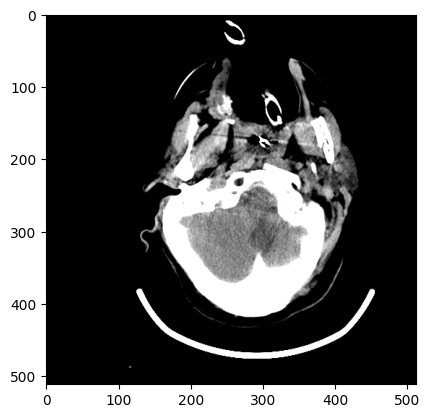

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
sample_png = os.path.join(train_png_dir, os.listdir(train_png_dir)[101])
img = Image.open(sample_png)
plt.imshow(img, cmap='gray')
plt.show()

In [8]:
# Cell 2.5: Preprocess Training and Test CSVs
import pandas as pd
import os

# Paths from Kaggle dataset
train_csv_input = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv'
test_csv_input = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv'
train_csv_output = '/kaggle/working/stage1_train_cls.csv'
test_csv_output = '/kaggle/working/stage2_test_cls.csv'

# Function to preprocess CSV
def preprocess_csv(input_path, output_path):
    # Load CSV
    csv = pd.read_csv(input_path)
    
    # Validate input
    print(f"Processing {input_path}")
    print(f"Initial shape: {csv.shape}")
    print(f"Columns: {csv.columns.tolist()}")
    
    # Check for missing or duplicate IDs
    if csv['ID'].duplicated().any():
        print(f"Warning: Found {csv['ID'].duplicated().sum()} duplicate IDs")
        print(csv[csv['ID'].duplicated()].head())
    
    # Extract study_instance_uid and label_type
    csv['study_instance_uid'] = csv['ID'].apply(lambda x: '_'.join(x.split('_')[:-1]))
    csv['label_type'] = csv['ID'].apply(lambda x: x.split('_')[-1])
    
    # Validate unique label types
    expected_labels = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    actual_labels = csv['label_type'].unique()
    print(f"Label types found: {actual_labels}")
    if not all(label in expected_labels for label in actual_labels):
        print(f"Warning: Unexpected label types: {set(actual_labels) - set(expected_labels)}")
    
    # Check for duplicates in study_instance_uid and label_type
    duplicates = csv.duplicated(subset=['study_instance_uid', 'label_type']).sum()
    if duplicates > 0:
        print(f"Warning: Found {duplicates} duplicate study_instance_uid/label_type combinations")
        print(csv[csv.duplicated(subset=['study_instance_uid', 'label_type'], keep=False)][['ID', 'study_instance_uid', 'label_type', 'Label']].head())
    
    # Use pivot_table to handle duplicates by taking the maximum label value
    pivot = csv.pivot_table(
        index='study_instance_uid',
        columns='label_type',
        values='Label',
        aggfunc='max'  # Take max if duplicate labels exist
    ).reset_index()
    
    # Add filename and slice_id
    pivot['filename'] = pivot['study_instance_uid'] + '.png'
    pivot['slice_id'] = pivot['study_instance_uid'] + '_0'
    
    # Ensure all expected label columns exist
    for label in expected_labels:
        if label not in pivot.columns:
            pivot[label] = 0  # Fill missing labels with 0
    
    # Reorder columns
    pivot = pivot[['filename', 'study_instance_uid', 'slice_id'] + expected_labels]
    
    # Save preprocessed CSV
    pivot.to_csv(output_path, index=False)
    print(f"Preprocessed CSV saved to: {output_path}")
    print(f"Output shape: {pivot.shape}")
    print(f"Output columns: {pivot.columns.tolist()}")
    
    return pivot

# Preprocess training and test CSVs
train_pivot = preprocess_csv(train_csv_input, train_csv_output)
test_pivot = preprocess_csv(test_csv_input, test_csv_output)

# Update paths in Cell 2 settings (for reference)
csv_path = train_csv_output
test_csv_path = test_csv_output

Processing /kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv
Initial shape: (4516842, 2)
Columns: ['ID', 'Label']
                                  ID  Label
56346          ID_a64d5deed_epidural      0
56347  ID_a64d5deed_intraparenchymal      0
56348  ID_a64d5deed_intraventricular      0
56349      ID_a64d5deed_subarachnoid      0
56350          ID_a64d5deed_subdural      0
Label types found: ['epidural' 'intraparenchymal' 'intraventricular' 'subarachnoid'
 'subdural' 'any']
                                  ID study_instance_uid        label_type  \
56340          ID_a64d5deed_epidural       ID_a64d5deed          epidural   
56341  ID_a64d5deed_intraparenchymal       ID_a64d5deed  intraparenchymal   
56342  ID_a64d5deed_intraventricular       ID_a64d5deed  intraventricular   
56343      ID_a64d5deed_subarachnoid       ID_a64d5deed      subarachnoid   
56344          ID_a64d5deed_subdural       ID_a64d5deed          subdural 

In [ ]:
import pandas as pd

# Show every row and every column (be careful with large frames!)
pd.set_option('display.max_rows', None)        # or an integer like 500
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)           # prevents line‐wrapping
pd.set_option('display.max_colwidth', None)    # show full string fields

display(train_pivot)   # or print(train_pivot)
display(test_pivot)


In [15]:
# Cell 2.6: Create K-Fold Splits
import pandas as pd
import os
from sklearn.model_selection import KFold

# Load preprocessed training CSV
csv_path = '/kaggle/working/stage1_train_cls.csv'
train_df = pd.read_csv(csv_path)

# Get unique study_instance_uids
study_ids = train_df['study_instance_uid'].unique()

# Define k-fold parameters
n_splits = 5
kfold_path = '/kaggle/working/fold_5_by_study_image/'

# Create 5-fold splits
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1992)
for fold, (train_idx, val_idx) in enumerate(kf.split(study_ids)):
    train_studies = study_ids[train_idx]
    val_studies = study_ids[val_idx]
    
    # Create fold directory
    fold_dir = os.path.join(kfold_path, f'fold{fold}')
    os.makedirs(fold_dir, exist_ok=True)
    
    # Save train.txt
    with open(os.path.join(fold_dir, 'train.txt'), 'w') as f:
        for study in train_studies:
            f.write(study + '\n')
    
    # Save val.txt
    with open(os.path.join(fold_dir, 'val.txt'), 'w') as f:
        for study in val_studies:
            f.write(study + '\n')
    
    print(f"Fold {fold}: {len(train_studies)} training studies, {len(val_studies)} validation studies")
    print(f"Files saved: {os.path.join(fold_dir, 'train.txt')}, {os.path.join(fold_dir, 'val.txt')}")

# Verify fold0 files
fold0_dir = os.path.join(kfold_path, 'fold0')
if os.path.exists(fold0_dir):
    with open(os.path.join(fold0_dir, 'train.txt'), 'r') as f:
        train_sample = f.readlines()[:5]
    with open(os.path.join(fold0_dir, 'val.txt'), 'r') as f:
        val_sample = f.readlines()[:5]
    print(f"Fold 0 train.txt sample: {train_sample}")
    print(f"Fold 0 val.txt sample: {val_sample}")
else:
    print(f"Error: Fold directory {fold0_dir} not found")

Fold 0: 602242 training studies, 150561 validation studies
Files saved: /kaggle/working/fold_5_by_study_image/fold0/train.txt, /kaggle/working/fold_5_by_study_image/fold0/val.txt
Fold 1: 602242 training studies, 150561 validation studies
Files saved: /kaggle/working/fold_5_by_study_image/fold1/train.txt, /kaggle/working/fold_5_by_study_image/fold1/val.txt
Fold 2: 602242 training studies, 150561 validation studies
Files saved: /kaggle/working/fold_5_by_study_image/fold2/train.txt, /kaggle/working/fold_5_by_study_image/fold2/val.txt
Fold 3: 602243 training studies, 150560 validation studies
Files saved: /kaggle/working/fold_5_by_study_image/fold3/train.txt, /kaggle/working/fold_5_by_study_image/fold3/val.txt
Fold 4: 602243 training studies, 150560 validation studies
Files saved: /kaggle/working/fold_5_by_study_image/fold4/train.txt, /kaggle/working/fold_5_by_study_image/fold4/val.txt
Fold 0 train.txt sample: ['ID_000012eaf\n', 'ID_000039fa0\n', 'ID_00005679d\n', 'ID_00008ce3c\n', 'ID_000

In [16]:
# Verification Code for Cell 2.5 and Cell 2.6
import pandas as pd
import os
import glob

# Paths
train_csv_output = '/kaggle/working/stage1_train_cls.csv'
test_csv_output = '/kaggle/working/stage2_test_cls.csv'
kfold_path = '/kaggle/working/fold_5_by_study_image/fold0/'
train_png_dir = '/kaggle/working/train_png/'
test_png_dir = '/kaggle/working/test_png/'

# Check CSVs
def verify_csv(csv_path, name):
    if not os.path.exists(csv_path):
        print(f"Error: {name} CSV not found at {csv_path}")
        return
    df = pd.read_csv(csv_path)
    expected_columns = ['filename', 'study_instance_uid', 'slice_id', 'any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    print(f"\nVerifying {name} CSV: {csv_path}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Missing columns: {set(expected_columns) - set(df.columns)}")
    print(f"Sample data:\n{df.head()}")
    # Check for missing or invalid values
    print(f"Missing values:\n{df.isnull().sum()}")
    print(f"Unique study_instance_uids: {df['study_instance_uid'].nunique()}")
    # Verify filenames exist in PNG directory
    png_dir = train_png_dir if 'train' in name.lower() else test_png_dir
    existing_pngs = set(os.listdir(png_dir))
    csv_filenames = set(df['filename'])
    missing_pngs = csv_filenames - existing_pngs
    print(f"PNG files missing for {len(missing_pngs)}/{len(csv_filenames)} filenames")
    if missing_pngs:
        print(f"Sample missing PNGs: {list(missing_pngs)[:5]}")

# Check k-fold files
def verify_kfold(fold_dir):
    train_txt = os.path.join(fold_dir, 'train.txt')
    val_txt = os.path.join(fold_dir, 'val.txt')
    print(f"\nVerifying k-fold files in {fold_dir}")
    for file_path in [train_txt, val_txt]:
        if not os.path.exists(file_path):
            print(f"Error: {file_path} not found")
            continue
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        print(f"{file_path}: {len(lines)} entries")
        print(f"Sample entries: {lines[:5]}")
    # Cross-check with CSV
    train_csv = pd.read_csv(train_csv_output)
    study_ids = set(train_csv['study_instance_uid'])
    with open(train_txt, 'r') as f:
        train_studies = set(line.strip() for line in f if line.strip())
    with open(val_txt, 'r') as f:
        val_studies = set(line.strip() for line in f if line.strip())
    print(f"Train studies in CSV: {len(train_studies & study_ids)}/{len(train_studies)}")
    print(f"Val studies in CSV: {len(val_studies & study_ids)}/{len(val_studies)}")

# Check disk space
import shutil
disk_usage = shutil.disk_usage('/kaggle/working/')
print(f"\nDisk space: {disk_usage.free / (1024**3):.2f} GB free of {disk_usage.total / (1024**3):.2f} GB")

# Run verifications
verify_csv(train_csv_output, "Training")
verify_csv(test_csv_output, "Test")
verify_kfold(kfold_path)

# Check PNG directories
print(f"\nTraining PNGs: {len(os.listdir(train_png_dir))}")
print(f"Sample training PNGs: {os.listdir(train_png_dir)[:5]}")
print(f"Test PNGs: {len(os.listdir(test_png_dir))}")
print(f"Sample test PNGs: {os.listdir(test_png_dir)[:5]}")


Disk space: 19.37 GB free of 19.52 GB

Verifying Training CSV: /kaggle/working/stage1_train_cls.csv
Shape: (752803, 9)
Columns: ['filename', 'study_instance_uid', 'slice_id', 'any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
Missing columns: set()
Sample data:
           filename study_instance_uid        slice_id  any  epidural  \
0  ID_000012eaf.png       ID_000012eaf  ID_000012eaf_0    0         0   
1  ID_000039fa0.png       ID_000039fa0  ID_000039fa0_0    0         0   
2  ID_00005679d.png       ID_00005679d  ID_00005679d_0    0         0   
3  ID_00008ce3c.png       ID_00008ce3c  ID_00008ce3c_0    0         0   
4  ID_0000950d7.png       ID_0000950d7  ID_0000950d7_0    0         0   

   intraparenchymal  intraventricular  subarachnoid  subdural  
0                 0                 0             0         0  
1                 0                 0             0         0  
2                 0                 0             0         0  
3     

In [17]:
# Cell 4: Data Augmentation and Dataset Utilities
import cv2
import numpy as np
import random
import math
import torch
import torch.utils.data as data
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import os

# Paths (from your input)
train_png_dir = '/kaggle/working/train_png/'
test_png_dir = '/kaggle/working/test_png/'
kfold_path = '/kaggle/working/fold_5_by_study_image/'
train_csv_path = '/kaggle/working/stage1_train_cls.csv'
test_csv_path = '/kaggle/working/stage2_test_cls.csv'

# Augmentation functions
def randomHorizontalFlip(image, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
    return image

def randomVerticleFlip(image, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 0)
    return image

def randomRotate90(image, u=0.5):
    if np.random.random() < u:
        image = np.rot90(image)
    return image

def random_cropping(image, ratio=0.8, is_random=True):
    height, width = image.shape[:2]
    target_h = int(height * ratio)
    target_w = int(width * ratio)
    if is_random:
        start_x = random.randint(0, width - target_w)
        start_y = random.randint(0, height - target_h)
    else:
        start_x = (width - target_w) // 2
        start_y = (height - target_h) // 2
    zeros = image[start_y:start_y+target_h, start_x:start_x+target_w]
    zeros = cv2.resize(zeros, (width, height))
    return zeros

def cropping(image, ratio=0.8, code=0):
    height, width = image.shape[:2]
    target_h = int(height * ratio)
    target_w = int(width * ratio)
    if code == 0:
        start_x = (width - target_w) // 2
        start_y = (height - target_h) // 2
    elif code == 1:
        start_x = 0
        start_y = 0
    elif code == 2:
        start_x = width - target_w
        start_y = 0
    elif code == 3:
        start_x = 0
        start_y = height - target_h
    elif code == 4:
        start_x = width - target_w
        start_y = height - target_h
    elif code == -1:
        return image
    zeros = image[start_y:start_y+target_h, start_x:start_x+target_w]
    zeros = cv2.resize(zeros, (width, height))
    return zeros

def random_erasing(img, probability=0.5, sl=0.02, sh=0.4, r1=0.3):
    if random.uniform(0, 1) > probability:
        return img
    for attempt in range(100):
        area = img.shape[0] * img.shape[1]
        target_area = random.uniform(sl, sh) * area
        aspect_ratio = random.uniform(r1, 1 / r1)
        h = int(round(math.sqrt(target_area * aspect_ratio)))
        w = int(round(math.sqrt(target_area / aspect_ratio)))
        if w < img.shape[1] and h < img.shape[0]:
            x1 = random.randint(0, img.shape[0] - h)
            y1 = random.randint(0, img.shape[1] - w)
            img[x1:x1 + h, y1:y1 + w] = 0.0
            return img
    return img

def randomShiftScaleRotate(image, shift_limit=(-0.1, 0.1), scale_limit=(-0.1, 0.1), rotate_limit=(-30, 30), aspect_limit=(-0.1, 0.1), borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width = image.shape[:2]
        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)
        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])
        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height]])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])
        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode, borderValue=0)
    return image

def aug_image(image, is_infer=False, augment=[0, 0]):
    if is_infer:
        image = randomHorizontalFlip(image, u=augment[0])
        image = cropping(image, ratio=0.8, code=augment[1])
        return image
    else:
        image = randomHorizontalFlip(image)
        image = randomVerticleFlip(image)
        image = randomRotate90(image)
        image = randomShiftScaleRotate(image, shift_limit=(-0.1, 0.1), scale_limit=(-0.1, 0.1), rotate_limit=(-30, 30), aspect_limit=(-0.1, 0.1))
        image = random_erasing(image, probability=0.5, sl=0.02, sh=0.4, r1=0.3)
        ratio = random.uniform(0.6, 0.99)
        image = random_cropping(image, ratio=ratio, is_random=True)
        return image

# Updated generate_random_list to handle edge cases
def generate_random_list(length):
    if length <= 0:
        return [0]  # Return default index to avoid empty list
    new_list = []
    for i in range(length):
        if i <= length / 2:
            weight = int(i / 4)
        else:
            weight = int((length - i) / 4)
        weight = max(1, weight)
        new_list += [i] * weight
    return new_list

# Define albumentations transforms
def generate_transforms(image_size):
    train_transform = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ])
    val_transform = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ])
    return train_transform, val_transform

# Dataset classes
class RSNA_Dataset_train_by_study_context(data.Dataset):
    def __init__(self, df, name_list, img_dir=train_png_dir, transform=None):
        # Validate name_list against df
        valid_names = set(df['study_instance_uid'])
        self.name_list = [name for name in name_list if name in valid_names]
        if len(self.name_list) < len(name_list):
            print(f"Warning: {len(name_list) - len(self.name_list)} study_instance_uids in name_list not found in df")
        self.df = df[df['study_instance_uid'].isin(self.name_list)]
        self.img_dir = img_dir
        self.transform = transform
        self.labels = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        # Check for empty DataFrame
        if self.df.empty:
            print("Error: DataFrame is empty after filtering with name_list")

    def __getitem__(self, idx):
        study_name = self.name_list[idx % len(self.name_list)]
        study_train_df = self.df[self.df['study_instance_uid'] == study_name]
        
        # Handle empty study_train_df
        if study_train_df.empty:
            print(f"Warning: No data for study_instance_uid {study_name}")
            image_cat = np.zeros((256, 256, 3), dtype=np.uint8)
            label = torch.FloatTensor([0, 0, 0, 0, 0, 0])
            if self.transform is not None:
                augmented = self.transform(image=image_cat)
                image_cat = augmented['image']
            return image_cat, label
        
        study_index = random.choice(generate_random_list(study_train_df.shape[0] - 1))
        slice_id = study_name + '_' + str(study_index)
        filename = study_train_df[study_train_df['slice_id'] == slice_id]['filename'].values
        if len(filename) == 0:
            print(f"Warning: No filename for slice_id {slice_id}")
            image_cat = np.zeros((256, 256, 3), dtype=np.uint8)
            label = torch.FloatTensor([0, 0, 0, 0, 0, 0])
            if self.transform is not None:
                augmented = self.transform(image=image_cat)
                image_cat = augmented['image']
            return image_cat, label
        filename = filename[0]
        
        # Load images (grayscale, single channel)
        image = cv2.imread(os.path.join(self.img_dir, filename), cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error loading image: {filename}")
            image = np.zeros((256, 256), dtype=np.uint8)
        
        # Load adjacent slices
        if study_index == (study_train_df.shape[0] - 1):
            filename_up = filename
        else:
            slice_id_up = study_name + '_' + str(study_index + 1)
            filename_up = study_train_df[study_train_df['slice_id'] == slice_id_up]['filename'].values
            filename_up = filename_up[0] if len(filename_up) > 0 else filename
        
        if study_index == 0:
            filename_down = filename
        else:
            slice_id_down = study_name + '_' + str(study_index - 1)
            filename_down = study_train_df[study_train_df['slice_id'] == slice_id_down]['filename'].values
            filename_down = filename_down[0] if len(filename_down) > 0 else filename
        
        image_up = cv2.imread(os.path.join(self.img_dir, filename_up), cv2.IMREAD_GRAYSCALE)
        if image_up is None:
            image_up = image.copy()
        image_down = cv2.imread(os.path.join(self.img_dir, filename_down), cv2.IMREAD_GRAYSCALE)
        if image_down is None:
            image_down = image.copy()
        
        # Resize to match Image_size=256
        image = cv2.resize(image, (256, 256))
        image_up = cv2.resize(image_up, (256, 256))
        image_down = cv2.resize(image_down, (256, 256))
        
        # Concatenate into 3-channel image
        image_cat = np.stack([image_up, image, image_down], axis=-1)
        
        # Get labels
        label = torch.FloatTensor(study_train_df[study_train_df['filename'] == filename][self.labels].values[0])
        
        # Apply augmentations
        image_cat = aug_image(image_cat, is_infer=False)
        if self.transform is not None:
            augmented = self.transform(image=image_cat)
            image_cat = augmented['image']
        
        return image_cat, label

    def __len__(self):
        return len(self.name_list) * 4

class RSNA_Dataset_val_by_study_context(data.Dataset):
    def __init__(self, df, name_list, img_dir=train_png_dir, transform=None):
        # Validate name_list against df
        valid_names = set(df['study_instance_uid'])
        self.name_list = [name for name in name_list if name in valid_names]
        if len(self.name_list) < len(name_list):
            print(f"Warning: {len(name_list) - len(self.name_list)} study_instance_uids in name_list not found in df")
        self.df = df[df['study_instance_uid'].isin(self.name_list)]
        self.img_dir = img_dir
        self.transform = transform
        self.labels = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        if self.df.empty:
            print("Error: DataFrame is empty after filtering with name_list")

    def __getitem__(self, idx):
        filename = self.name_list[idx % len(self.name_list)]
        filename_train_df = self.df[self.df['filename'] == filename]
        if filename_train_df.empty:
            print(f"Warning: No data for filename {filename}")
            image_cat = np.zeros((256, 256, 3), dtype=np.uint8)
            label = torch.FloatTensor([0, 0, 0, 0, 0, 0])
            if self.transform is not None:
                augmented = self.transform(image=image_cat)
                image_cat = augmented['image']
            return image_cat, label
        
        study_name = filename_train_df['study_instance_uid'].values[0]
        study_index = int(filename_train_df['slice_id'].values[0].split('_')[-1])
        study_train_df = self.df[self.df['study_instance_uid'] == study_name]
        
        # Load images (grayscale, single channel)
        image = cv2.imread(os.path.join(self.img_dir, filename), cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error loading image: {filename}")
            image = np.zeros((256, 256), dtype=np.uint8)
        
        # Load adjacent slices
        if study_index == (study_train_df.shape[0] - 1):
            filename_up = filename
        else:
            slice_id_up = study_name + '_' + str(study_index + 1)
            filename_up = study_train_df[study_train_df['slice_id'] == slice_id_up]['filename'].values
            filename_up = filename_up[0] if len(filename_up) > 0 else filename
        
        if study_index == 0:
            filename_down = filename
        else:
            slice_id_down = study_name + '_' + str(study_index - 1)
            filename_down = study_train_df[study_train_df['slice_id'] == slice_id_down]['filename'].values
            filename_down = filename_down[0] if len(filename_down) > 0 else filename
        
        image_up = cv2.imread(os.path.join(self.img_dir, filename_up), cv2.IMREAD_GRAYSCALE)
        if image_up is None:
            image_up = image.copy()
        image_down = cv2.imread(os.path.join(self.img_dir, filename_down), cv2.IMREAD_GRAYSCALE)
        if image_down is None:
            image_down = image.copy()
        
        # Resize to match Image_size=256
        image = cv2.resize(image, (256, 256))
        image_up = cv2.resize(image_up, (256, 256))
        image_down = cv2.resize(image_down, (256, 256))
        
        # Concatenate into 3-channel image
        image_cat = np.stack([image_up, image, image_down], axis=-1)
        
        # Get labels
        label = torch.FloatTensor(study_train_df[study_train_df['filename'] == filename][self.labels].values[0])
        
        # Apply augmentations
        image_cat = aug_image(image_cat, is_infer=True)
        if self.transform is not None:
            augmented = self.transform(image=image_cat)
            image_cat = augmented['image']
        
        return image_cat, label

    def __len__(self):
        return len(self.name_list)

class PredictionDatasetPure(data.Dataset):
    def __init__(self, name_list, df_train, df_test, n_test_aug, mode, img_dir):
        self.name_list = name_list
        self.mode = mode
        self.n_test_aug = n_test_aug
        self.img_dir = train_png_dir if mode == 'val' else test_png_dir
        if mode == 'val':
            self.df = df_train[df_train['filename'].isin(name_list)]
        elif mode == 'test':
            self.df = df_test[df_test['filename'].isin(name_list)]
        self.labels = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        if self.df.empty:
            print(f"Error: DataFrame is empty for mode {mode}")

    def __len__(self):
        return len(self.name_list) * self.n_test_aug

    def __getitem__(self, idx):
        filename = self.name_list[idx % len(self.name_list)]
        image_cat = cv2.imread(os.path.join(self.img_dir, filename), cv2.IMREAD_GRAYSCALE)
        if image_cat is None:
            print(f"Error loading image: {filename}")
            image_cat = np.zeros((256, 256), dtype=np.uint8)
        image_cat = cv2.resize(image_cat, (256, 256))
        image_cat = np.stack([image_cat, image_cat, image_cat], axis=-1)
        label = torch.FloatTensor(self.df[self.df['filename'] == filename][self.labels].values[0] if self.mode == 'val' else [0, 0, 0, 0, 0, 0])
        image_cat = aug_image(image_cat, is_infer=True)
        image_cat = valid_transform_pure(image=image_cat)['image']
        return filename, image_cat, label

class PredictionDatasetAug(data.Dataset):
    def __init__(self, name_list, df_train, df_test, n_test_aug, mode, img_dir):
        self.name_list = name_list
        self.mode = mode
        self.n_test_aug = n_test_aug
        self.img_dir = train_png_dir if mode == 'val' else test_png_dir
        if mode == 'val':
            self.df = df_train[df_train['filename'].isin(name_list)]
        elif mode == 'test':
            self.df = df_test[df_test['filename'].isin(name_list)]
        self.labels = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        if self.df.empty:
            print(f"Error: DataFrame is empty for mode {mode}")

    def __len__(self):
        return len(self.name_list) * self.n_test_aug

    def __getitem__(self, idx):
        filename = self.name_list[idx % len(self.name_list)]
        image_cat = cv2.imread(os.path.join(self.img_dir, filename), cv2.IMREAD_GRAYSCALE)
        if image_cat is None:
            print(f"Error loading image: {filename}")
            image_cat = np.zeros((256, 256), dtype=np.uint8)
        image_cat = cv2.resize(image_cat, (256, 256))
        image_cat = np.stack([image_cat, image_cat, image_cat], axis=-1)
        if random.random() < 0.5:
            image_cat = cv2.cvtColor(image_cat, cv2.COLOR_GRAY2RGB)
        image_cat = randomHorizontalFlip(image_cat, u=0.5)
        ratio = random.uniform(0.6, 0.99)
        image_cat = random_cropping(image_cat, ratio=ratio, is_random=True)
        image_cat = valid_transform_aug(image=image_cat)['image']
        label = torch.FloatTensor(self.df[self.df['filename'] == filename][self.labels].values[0] if self.mode == 'val' else [0, 0, 0, 0, 0, 0])
        return filename, image_cat, label

# Validation transforms
valid_transform_aug = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, p=1.0),
    ToTensorV2()
])

valid_transform_pure = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, p=1.0),
    ToTensorV2()
])

def generate_dataset_loader(df_all, c_train, train_transform, train_batch_size, c_val, val_transform, val_batch_size, workers):
    train_dataset = RSNA_Dataset_train_by_study_context(df_all, c_train, train_png_dir, train_transform)
    val_dataset = RSNA_Dataset_val_by_study_context(df_all, c_val, train_png_dir, val_transform)
    train_loader = data.DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=workers, pin_memory=True, drop_last=True)
    val_loader = data.DataLoader(
        val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)
    return train_loader, val_loader

# Test dataset (for verification)
if __name__ == "__main__":
    df_train = pd.read_csv(train_csv_path)
    df_test = pd.read_csv(test_csv_path)

    # Your specific image filenames
    sample_filenames = [
        'ID_0161aacd7.png',
        'ID_0196d1a8c.png',
        'ID_023f03565.png'
    ]

    n_test_aug = 1  # Set to >1 if you want test-time augmentation
    mode = 'val'  # Since these are from training PNGs

    dataset = PredictionDatasetPure(
        name_list=sample_filenames,
        df_train=df_train,
        df_test=df_test,
        n_test_aug=n_test_aug,
        mode=mode,
        img_dir=train_png_dir
    )

    loader = data.DataLoader(dataset, batch_size=3, shuffle=False)

    for filenames, images, labels in loader:
        print(f"Filenames: {filenames}")
        print(f"Images shape: {images.shape}")
        print(f"Labels: {labels}")
        break

   

Filenames: ('ID_0161aacd7.png', 'ID_0196d1a8c.png', 'ID_023f03565.png')
Images shape: torch.Size([3, 3, 256, 256])
Labels: tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])


In [19]:
# Cell 5: Loss Functions and Evaluation Metrics
import torch
import torch.nn as nn
import numpy as np

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight  # Optional class weights for imbalanced data

    def forward(self, input, target):
        # input: (batch_size, num_classes), target: (batch_size, num_classes)
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none', pos_weight=self.weight)(input, target)
        pt = torch.exp(-BCE_loss)  # Probability of target
        focal_loss = (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

def rsna_log_loss(outputs, targets, weights=None):
    """
    Compute weighted multi-label log loss for RSNA competition.
    outputs: (batch_size, num_classes) - Model logits (before sigmoid)
    targets: (batch_size, num_classes) - Ground truth labels (0 or 1)
    weights: (num_classes,) - Weights for each class (default: equal weights)
    """
    if weights is None:
        weights = torch.ones(outputs.shape[1], device=outputs.device)
    else:
        weights = torch.tensor(weights, device=outputs.device)
    
    # Apply sigmoid to outputs
    outputs = torch.sigmoid(outputs)
    
    # Clip outputs to avoid log(0)
    outputs = outputs.clamp(min=1e-7, max=1-1e-7)
    
    # Compute binary cross-entropy per class
    loss = -weights * (targets * torch.log(outputs) + (1 - targets) * torch.log(1 - outputs))
    
    # Average over classes and batch
    return loss.mean()


# Include other loss functions from loss_function.py as needed (e.g., FocalLoss_BCE, SoftDiceLoss, etc.)

def computeAUROC(dataGT, dataPRED, classCount):
    outAUROC = []
    datanpGT = dataGT.cpu().numpy()
    datanpPRED = dataPRED.cpu().numpy()
    for i in range(classCount):
        outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
    return outAUROC

def weighted_log_loss(output, target, weight=[1, 1, 1, 1, 1, 1]):
    loss = torch.nn.BCELoss()
    loss_list = []
    for i in range(output.shape[1]):
        output_class = output[:, i]
        target_class = target[:, i]
        loss_class = loss(output_class, target_class)
        loss_list.append(float(loss_class.cpu().numpy()))
    loss_sum = np.mean(np.array(weight) * np.array(loss_list))
    loss_list = [round(x, 4) for x in loss_list]
    loss_sum = round(loss_sum, 4)
    return loss_list, loss_sum

def weighted_log_loss_numpy(output, target, weight=[1, 1, 1, 1, 1, 1]):
    loss_list = []
    for i in range(output.shape[1]):
        output_class = output[:, i]
        target_class = target[:, i]
        loss_class = log_loss(target_class.ravel(), output_class.ravel(), eps=1e-7)
        loss_list.append(loss_class)
    loss_sum = np.mean(np.array(weight) * np.array(loss_list))
    loss_list = [round(x, 4) for x in loss_list]
    loss_sum = round(loss_sum, 4)
    return loss_list, loss_sum

In [20]:
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import Optimizer
import numpy as np
import math

class WarmRestart(lr_scheduler.CosineAnnealingLR):
    def __init__(self, optimizer, T_max=10, T_mult=2, eta_min=0, last_epoch=-1):
        self.T_mult = T_mult
        super().__init__(optimizer, T_max, eta_min, last_epoch)

    def get_lr(self):
        if self.last_epoch == self.T_max:
            self.last_epoch = 0
            self.T_max *= self.T_mult
        return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2 for base_lr in self.base_lrs]

def warm_restart(scheduler, T_mult=2):
    if scheduler.last_epoch == scheduler.T_max:
        scheduler.last_epoch = -1
        scheduler.T_max *= T_mult
    return scheduler

class AdamW(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)
        return loss

In [21]:
# Cell 7: Model Definitions
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1, 1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)

    def forward(self, x):
        return torch.cat([self.ap(x), self.mp(x)], 1)

class DenseNet121_change_avg(nn.Module):
    def __init__(self):
        super(DenseNet121_change_avg, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU()
        self.mlp = nn.Linear(1024, 6)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.densenet121(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = x.view(-1, 1024)
        x = self.mlp(x)
        return x

class DenseNet169_change_avg(nn.Module):
    def __init__(self):
        super(DenseNet169_change_avg, self).__init__()
        self.densenet169 = torchvision.models.densenet169(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.relu = nn.ReLU()
        self.mlp = nn.Linear(1664, 6)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.densenet169(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x

class se_resnext101_32x4d(nn.Module):
    def __init__(self):
        super(se_resnext101_32x4d, self).__init__()
        self.model_ft = pretrainedmodels.__dict__['se_resnext101_32x4d'](num_classes=1000, pretrained='imagenet')
        num_ftrs = self.model_ft.last_linear.in_features
        self.model_ft.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.model_ft.last_linear = nn.Sequential(nn.Linear(num_ftrs, 6, bias=True))

    def forward(self, x):
        x = self.model_ft(x)
        return x

In [23]:
# Cell 8: Training Loop
def epochVal(model, dataLoader, loss_cls, c_val, val_batch_size):
    model.eval()
    lossValNorm = 0
    valLoss = 0
    outGT = torch.FloatTensor().cuda()
    outPRED = torch.FloatTensor().cuda()
    for i, (input, target) in enumerate(dataLoader):
        if i == 0:
            ss_time = time.time()
        print(f"{i}/{int(len(c_val)/val_batch_size)}     {(time.time()-ss_time)/(i+1)}", end='\r')
        target = target.view(-1, 6).contiguous().cuda()
        outGT = torch.cat((outGT, target), 0)
        varInput = torch.autograd.Variable(input)
        varTarget = torch.autograd.Variable(target.contiguous().cuda())
        varOutput = model(varInput)
        lossvalue = loss_cls(varOutput, varTarget)
        valLoss = valLoss + lossvalue.item()
        varOutput = varOutput.sigmoid()
        outPRED = torch.cat((outPRED, varOutput.data), 0)
        lossValNorm += 1
    valLoss = valLoss / lossValNorm
    auc = computeAUROC(outGT, outPRED, 6)
    auc = [round(x, 4) for x in auc]
    loss_list, loss_sum = weighted_log_loss(outPRED, outGT)
    return valLoss, auc, loss_list, loss_sum

def train(model_name, image_size):
    if not os.path.exists(snapshot_path):
        os.makedirs(snapshot_path)
    header = ['Epoch', 'Learning rate', 'Time', 'Train Loss', 'Val Loss']
    if not os.path.isfile(os.path.join(snapshot_path, 'log.csv')):
        with open(os.path.join(snapshot_path, 'log.csv'), 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header)
    df_all = pd.read_csv(csv_path)
    kfold_path_train = '../data/fold_5_by_study/'
    kfold_path_val = '../data/fold_5_by_study_image/'
    for num_fold in range(5):
        print(f'fold_num: {num_fold}')
        with open(os.path.join(snapshot_path, 'log.csv'), 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([num_fold])
        f_train = open(os.path.join(kfold_path_train, f'fold{num_fold}/train.txt'), 'r')
        f_val = open(os.path.join(kfold_path_val, f'fold{num_fold}/val.txt'), 'r')
        c_train = f_train.readlines()
        c_val = f_val.readlines()
        f_train.close()
        f_val.close()
        c_train = [s.replace('\n', '') for s in c_train]
        c_val = [s.replace('\n', '') for s in c_val]
        print(f'train dataset study num: {len(c_train)}  val dataset image num: {len(c_val)}')
        with open(os.path.join(snapshot_path, 'log.csv'), 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['train dataset:', len(c_train), 'val dataset:', len(c_val)])
            writer.writerow(['train_batch_size:', train_batch_size, 'val_batch_size:', val_batch_size])
        train_transform, val_transform = generate_transforms(image_size)
        train_loader, val_loader = generate_dataset_loader(df_all, c_train, train_transform, train_batch_size, c_val, val_transform, val_batch_size, workers)
        model = eval(model_name + '()')
        model = model.cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00002)
        scheduler = WarmRestart(optimizer, T_max=5, T_mult=1, eta_min=1e-5)
        model = torch.nn.DataParallel(model)
        loss_cls = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda())
        trMaxEpoch = 80
        for epochID in range(0, trMaxEpoch):
            start_time = time.time()
            model.train()
            trainLoss = 0
            lossTrainNorm = 10
            if epochID < 10:
                pass
            elif epochID < 80:
                if epochID != 10:
                    scheduler.step()
                    scheduler = warm_restart(scheduler, T_mult=2)
            else:
                optimizer.param_groups[0]['lr'] = 1e-5
            for batchID, (input, target) in enumerate(train_loader):
                if batchID == 0:
                    ss_time = time.time()
                print(f"{batchID}/{int(len(c_train)/train_batch_size)}     {(time.time()-ss_time)/(batchID+1)}", end='\r')
                varInput = torch.autograd.Variable(input)
                target = target.view(-1, 6).contiguous().cuda()
                varTarget = torch.autograd.Variable(target.contiguous().cuda())
                varOutput = model(varInput)
                lossvalue = loss_cls(varOutput, varTarget)
                trainLoss = trainLoss + lossvalue.item()
                lossTrainNorm = lossTrainNorm + 1
                lossvalue.backward()
                optimizer.step()
                optimizer.zero_grad()
                del lossvalue
            trainLoss = trainLoss / lossTrainNorm
            if (epochID + 1) % 5 == 0 or epochID > 79 or epochID == 0:
                valLoss, auc, loss_list, loss_sum = epochVal(model, val_loader, loss_cls, c_val, val_batch_size)
            epoch_time = time.time() - start_time
            if (epochID + 1) % 5 == 0 or epochID > 79:
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'valLoss': valLoss}, os.path.join(snapshot_path, f'model_epoch_{epochID}_{num_fold}.pth'))
            result = [epochID, round(optimizer.state_dict()['param_groups'][0]['lr'], 6), round(epoch_time, 0), round(trainLoss, 5), round(valLoss, 5), 'auc:', auc, 'loss:', loss_list, loss_sum]
            print(result)
            with open(os.path.join(snapshot_path, 'log.csv'), 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(result)
        del model

# Run training
train(backbone, Image_size)

Training failed: K-fold train files not found


In [23]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt

from albumentations.pytorch import ToTensorV2
import albumentations as A

from torch.utils.data import DataLoader

# Paths
train_png_dir = '/kaggle/working/train_png/'
test_png_dir = '/kaggle/working/test_png/'
kfold_path = '/kaggle/working/fold_5_by_study_image/'
train_csv_path = '/kaggle/working/stage1_train_cls.csv'
test_csv_path = '/kaggle/working/stage2_test_cls.csv'


In [24]:
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)
print("Train CSV shape:", df_train.shape)
print("Test CSV shape:", df_test.shape)


Train CSV shape: (752803, 9)
Test CSV shape: (121232, 9)


In [25]:
train_txt = os.path.join(kfold_path, 'fold0/train.txt')
val_txt = os.path.join(kfold_path, 'fold0/val.txt')

with open(train_txt, 'r') as f:
    c_train = [line.strip() for line in f]

with open(val_txt, 'r') as f:
    c_val = [line.strip() for line in f]

print("Train IDs:", len(c_train))
print("Val IDs:", len(c_val))


Train IDs: 602242
Val IDs: 150561


In [27]:
def generate_transforms(image_size=256):
    transform = A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2()
    ])
    return transform, transform

train_transform, val_transform = generate_transforms(256)


Study ID: ID_0161aacd7
Image shape: torch.Size([3, 256, 256])
Label: tensor([0., 0., 0., 0., 0., 0.])


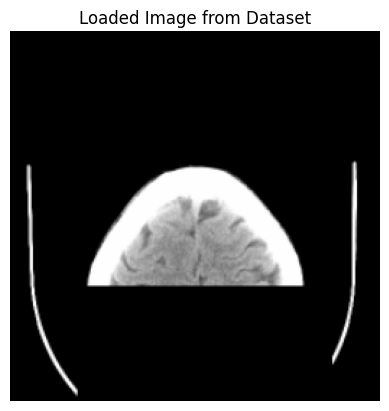

In [28]:
# Path and filename to test
test_file = "ID_0161aacd7.png"
img_path = os.path.join(train_png_dir, test_file)

# Confirm the file exists
assert os.path.exists(img_path), f"{img_path} does not exist."

# Find corresponding study info from df_train
row = df_train[df_train['filename'] == test_file]
if row.empty:
    raise ValueError(f"Filename {test_file} not found in df_train")

# Get study_instance_uid and slice_id
study_id = row.iloc[0]['study_instance_uid']
print("Study ID:", study_id)

# Create mini dataset using only this study
c_train_single = [study_id]

# Initialize dataset
dataset = RSNA_Dataset_train_by_study_context(df_train, c_train_single, train_png_dir, train_transform)

# Load and display
image, label = dataset[0]
print("Image shape:", image.shape)
print("Label:", label)

# Visualize
plt.imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.title("Loaded Image from Dataset")
plt.axis("off")
plt.show()


In [30]:
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

for i, (images, labels) in enumerate(train_loader):
    print(f"[Batch {i}] Image shape: {images.shape}, Label shape: {labels.shape}")
    break


[Batch 0] Image shape: torch.Size([4, 3, 256, 256]), Label shape: torch.Size([4, 6])


/tmp/ipykernel_36/1995812842.py:101: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  cc = np.math.cos(angle / 180 * np.math.pi) * sx
/tmp/ipykernel_36/1995812842.py:102: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  ss = np.math.sin(angle / 180 * np.math.pi) * sy
/tmp/ipykernel_36/1995812842.py:101: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  cc = np.math.cos(angle / 180 * np.math.pi) * sx
/tmp/ipykernel_36/1995812842.py:102: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  ss = np.math.sin(angle / 180 * np.math.pi) * sy


In [32]:

for images, labels in train_loader:
    
    print(f"Image batch shape: {images.shape}")  # e.g. (32, 3, 256, 256)
    img = images[0]  # First image from batch
    print(f"First image shape: {img.shape}")  # Should be [3, 256, 256]
    print(f"Channel 0 (Up slice) mean: {img[0].mean().item()}")
    print(f"Channel 1 (Center slice) mean: {img[1].mean().item()}")
    print(f"Channel 2 (Down slice) mean: {img[2].mean().item()}")
    break
print(f"Mean raw intensities before normalization:")
print(f"  Up: {image_up.mean()}, Mid: {image.mean()}, Down: {image_down.mean()}")


Image batch shape: torch.Size([4, 3, 256, 256])
First image shape: torch.Size([3, 256, 256])
Channel 0 (Up slice) mean: -0.5426850914955139
Channel 1 (Center slice) mean: -0.5426850914955139
Channel 2 (Down slice) mean: -0.5426850914955139
Mean raw intensities before normalization:


/tmp/ipykernel_36/1995812842.py:101: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  cc = np.math.cos(angle / 180 * np.math.pi) * sx
/tmp/ipykernel_36/1995812842.py:102: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  ss = np.math.sin(angle / 180 * np.math.pi) * sy
/tmp/ipykernel_36/1995812842.py:101: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  cc = np.math.cos(angle / 180 * np.math.pi) * sx
/tmp/ipykernel_36/1995812842.py:102: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  ss = np.math.sin(angle / 180 * np.math.pi) * sy


NameError: name 'image_up' is not defined

/tmp/ipykernel_36/249092492.py:101: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  cc = np.math.cos(angle / 180 * np.math.pi) * sx
/tmp/ipykernel_36/249092492.py:102: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  ss = np.math.sin(angle / 180 * np.math.pi) * sy


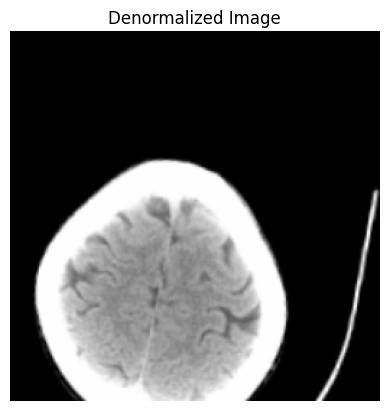

In [22]:
# Load one sample from the dataset
img_tensor, _ = dataset[0]

# Convert to NumPy and denormalize
img_np = img_tensor.permute(1, 2, 0).numpy()
img_np = (img_np * 0.5 + 0.5).clip(0, 1)  # undo normalization

# Show the image
plt.imshow(img_np)
plt.title("Denormalized Image")
plt.axis("off")
plt.show()


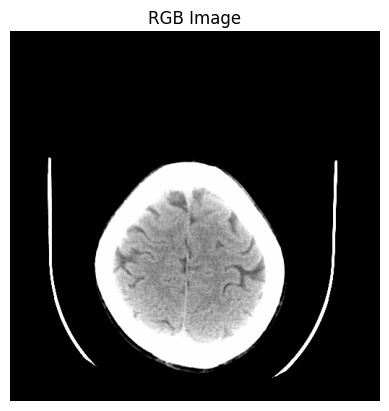

In [23]:
import cv2
import matplotlib.pyplot as plt

# Load and convert BGR (OpenCV default) to RGB
img = cv2.imread("/kaggle/working/train_png/ID_0161aacd7.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("RGB Image")
plt.axis("off")
plt.show()


/tmp/ipykernel_36/249092492.py:101: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  cc = np.math.cos(angle / 180 * np.math.pi) * sx
/tmp/ipykernel_36/249092492.py:102: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  ss = np.math.sin(angle / 180 * np.math.pi) * sy


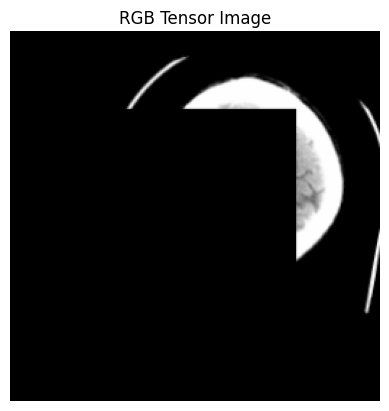

In [24]:
def denormalize(tensor):
    # Assuming normalization: (x - 0.5)/0.5 → x = x*0.5 + 0.5
    return tensor * 0.5 + 0.5

# Load one sample
image_tensor, _ = dataset[0]  # shape: [3, 256, 256]

# Denormalize and permute
img_np = denormalize(image_tensor).permute(1, 2, 0).cpu().numpy()

# Show
plt.imshow(img_np)
plt.title("RGB Tensor Image")
plt.axis("off")
plt.show()


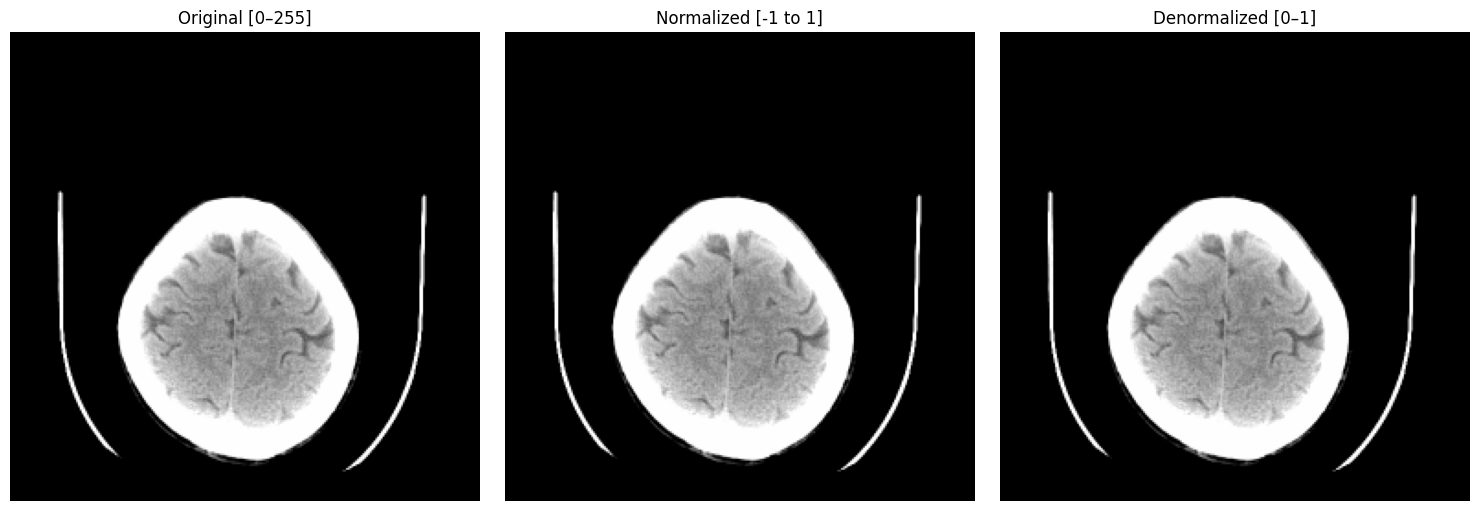

In [25]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load image using OpenCV
img_path = "/kaggle/working/train_png/ID_0161aacd7.png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Resize (optional)
img = cv2.resize(img, (256, 256))

# Step 2: Normalize image (like Albumentations Normalize does)
img_normalized = img / 255.0
img_normalized = (img_normalized - 0.5) / 0.5  # Normalize to [-1, 1]

# Step 3: Convert to tensor
img_tensor = torch.from_numpy(img_normalized).permute(2, 0, 1).float()

# Step 4: Denormalize for visualization
img_denormalized = img_tensor * 0.5 + 0.5  # back to [0, 1]
img_denorm_np = img_denormalized.permute(1, 2, 0).numpy()

# Step 5: Show all three images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original
axes[0].imshow(img)
axes[0].set_title("Original [0–255]")
axes[0].axis("off")

# Normalized
axes[1].imshow(((img_tensor.permute(1, 2, 0)).numpy() + 1) / 2)
axes[1].set_title("Normalized [-1 to 1]")
axes[1].axis("off")

# Denormalized
axes[2].imshow(img_denorm_np)
axes[2].set_title("Denormalized [0–1]")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [1]:
image, label = dataset[0]  # Assuming your dataset returns (image, label)

print("Image Tensor Shape:", image.shape)  # Should be [3, 256, 256]
print("Is Tensor:", isinstance(image, torch.Tensor))

# Convert to numpy for channel inspection
image_np = image.permute(1, 2, 0).cpu().numpy()  # [H, W, C]

# Check each channel
channel_0 = image_np[:, :, 0]
channel_1 = image_np[:, :, 1]
channel_2 = image_np[:, :, 2]

# Check differences between channels
print("Channel 0 == Channel 1:", np.array_equal(channel_0, channel_1))
print("Channel 1 == Channel 2:", np.array_equal(channel_1, channel_2))


NameError: name 'dataset' is not defined